# Import Python Libraries

In [1]:
#Import Modules and Function
import sys
import time
from datetime import datetime, timedelta
import pymongo

import pandas as pd
import numpy as np
import re
import string
import collections
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


import nltk
from nltk.util import ngrams
from nltk.tokenize import TweetTokenizer, WordPunctTokenizer, word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

import gensim 
from gensim import corpora
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
import pyLDAvis.gensim

C:\Users\ngwei\Anaconda3\lib\site-packages\past\builtins\misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping


## Analysis on Specific Date: 

In [2]:
# Manually adjust day/date

varYr = 2020
varMonth = 8
varDay = 8
varDate = datetime(varYr, varMonth, varDay)
strDate = datetime.strftime(varDate, '%m/%d/%Y')

# ASSERT: Make sure MongoDB is not empty, else will produce errors

## Connect to MongoDB Instance


In [3]:
# MONGODB Instance

# Localhost
# mongo_client = pymongo.MongoClient('mongodb://127.0.0.1:27017/')
# mongo_db = mongo_client['datafyp']
# mongo_collection = mongo_db['fyptwitter']
# mongo_collection = mongo_db['fypreddit']

# Remote MongoDB Server
mongo_client = pymongo.MongoClient('mongodb://192.168.0.134:27017/')
mongo_db = mongo_client['datafyp']

# NWX Note: Get the correct IP for remote server!

# Part1: Twitter Data
- Read from MongoDB
- Data Cleaning
- Run Sentiment Analysis
- Perform Topic Modelling

In [4]:
# Recording start time for Twitter Part
starttime = time.time()

In [5]:
%%time 

# Access Twitter Collection in MongoDB 
mongo_collection = mongo_db['fyptwitter']

# reference: https://stackoverflow.com/questions/26366417/how-to-make-a-query-date-in-mongodb-using-pymongo
start = datetime(varYr, varMonth, varDay, 0, 0, 1) + timedelta(hours=4)
end = datetime(varYr, varMonth, varDay, 23, 59, 59) + timedelta(hours=4)
# Note: Time-displacement 4 hours. Washington DC is UTC-4, but in fact Twitter data stored in UTC time

dftwit = pd.DataFrame(list(mongo_collection.find( {'created_at': {'$lt': end, '$gte': start}})))

Wall time: 52.3 s


### Twitter Data Pre-Processing


In [6]:
# Use only English tweets for US context
dftwit = dftwit[dftwit['lang']=='en']

# Include duplicates to get overall stance prediction
# Use Quote (replies) if available, else Retain full_text
dftwit['text'] = dftwit.apply(lambda row: row['quote_text'] if (row['is_quote_status'] == True) else row['full_text'], axis=1)

# Adjust time back to UTC-4
dftwit['created_at'] = dftwit['created_at'].apply(lambda x: x-timedelta(hours=4))

# drop other columns, keep only timestamp and text
dftwit = dftwit[['created_at', 'text']]

### Initial EDA


In [7]:
# # Number of Words
# dftwit['word_count'] = dftwit['text'].apply(lambda x: len(str(x).split(" ")))

# # Number of Character
# dftwit['char_count'] = dftwit['text'].str.len()

# # Number of hashtags
# dftwit['hashtag'] = dftwit['text'].str.count("#")

# # Number of mentions
# dftwit['mention'] = dftwit['text'].str.count("@")

# # Number of URLs
# dftwit['url'] = dftwit['text'].str.count('http')

In [8]:
# dftwit[['word_count', 'char_count', 'hashtag', 'mention', 'url']].describe()

In [9]:
# # Distribution of Word-Count (Text)
# plt.figure(dpi = 120)
# sns.distplot(dftwit.word_count, hist=False, color = 'green')

### Text Preprocessing

1. Converting texts to lower case
2. Replacing keywords
3. Negation keywords
4. Removing URLs
5. Removing Tagging / Mentions
6. Removing single-char words
7. Removing punctuations | numerical values | non-English characters
8. Keeping Emoji | Alphabets
9. Removing stop words
10. Tokenize text
11. Part of Speech (POS) tagging 
12. Lemmatization



### ReGex text patterns
Reference: https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b

keep a-z A-Z and Emojis

remove numbers, punctuations, special languages (eg Chinese Russian Hindi)


In [10]:
text_pattern = re.compile("[^"
        u"a-zA-Z"                 # alphabets
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        #u"\U0001F680-\U0001F6FF"  # transport & map symbols
        #u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        #u"\U00002500-\U00002BEF"
        #u"\U000024C2-\U0001F251"  # chinese / asian char
        u"\U00002702-\U000027B0"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
        "]+", flags=re.UNICODE)


### Stop Words

Base dictionary from Kaggle Dataset
- Reference: https://www.kaggle.com/rtatman/stopword-lists-for-19-languages?select=englishST.txt

Append additional stopwords

Remove negation keywords from dictionary (crucial for sentiment analysis)

In [11]:
# StopWords

# (NLTK English corpus)
stop_words = stopwords.words("english")

# Manually adding keywords to list of stopwords
addstopwords = ['retweet', 'rt']
stop_words.extend(addstopwords)

# Remove certain keywords from dictionary
removestopwords = ['not', 'but', 'believe', 'certainly', 'clearly', 'consequently', 'definitely', 'downwards', 'entirely', 'especially', 'exactly', 'except', 'hardly', 'hence', 'hopefully', 'however', 'immediate', 'inasmuch', 'indeed', 'insofar', 'least', 'less', 'merely', 'more', 'moreover', 'most', 'mostly', 'much', 'must', 'necessary', 'obviously', 'otherwise', 'particular', 'particularly', 'perhaps', 'possible', 'probably', 'presumably', 'reasonably', 'regardless', 'relatively', 'serious', 'seriously', 'sure', 'thorough', 'thoroughly', 'truly', 'unfortunately', 'unless', 'unlikely', 'useful']
stop_words = [ele for ele in stop_words if ele not in removestopwords]

# print(stop_words)

### Replacing target-specific keywords

Standardize related keywords

In [12]:
# Standardize and Replace specific keywords

# donaldtrump
tagTrump = {'@realdonaldtrump'}
keyTrump = {'donald trump', '#trump', 'trump', '#donaldtrump'} 

# joebiden
tagBiden = {'@joebiden'}
keyBiden = {'joe biden', 'biden', "#joebiden", '#biden'} 

# negation keywords
keyNegation = {'never', 'not', 'no', 'nor', 'non', 'none', "isn't", "isnt", "wasn't", "wasnt", "weren't", "ain't", "aren't", "don't", 'dont', 'doesnt', "doesn't", "didn't", 'dint', "hadn't", "hasn't", "haven't", "shouldn't", 'shouldnt', "can't", 'cannot', 'cant', "couldn't"}

### POS-Tagging and Lemmatization

In [13]:
# Declare Lemmatizer from NLTK Library
wordnet_lemmatizer = WordNetLemmatizer()
# Ref: https://www.machinelearningplus.com/nlp/lemmatization-examples-python/

# Declare Tokenizer from NLTK Library
TweetTokeniser = TweetTokenizer()

# POS-Tagging
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# Lemmatization
def lemmatize_sentence(wordlist):
    # find the POS tag for each token
    nltk_tagged = nltk.pos_tag(wordlist)
    # tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(wordnet_lemmatizer.lemmatize(word, tag))
    return (" ".join(lemmatized_sentence)).strip()

### Summary: Function to clean twitter texts

In [14]:
# Functions to clean twitter texts
def tweet_cleaner(text):
    
    # convert all texts to lower case
    text = text.lower()
    
    # replace keywords: donaldtrump
    text = re.sub('|'.join(r"(?<=\s){}(?=\b)".format(i) for i in tagTrump), 'donaldtrump', " "+text+" ")
    
    # replace keywords: joebiden
    text = re.sub('|'.join(r"(?<=\s){}(?=\b)".format(i) for i in tagBiden), 'joebiden', " "+text+" ")
    
    # replace keywords: negation
    text = re.sub('|'.join(r"(?<=\s){}(?=\b)".format(i) for i in keyNegation), 'not', " "+text+" ")
    
    # unescaping HTML changing '&amp;' to 'and'
    text = text.replace('&amp;','and')
    
    # remove URLs
    text = re.sub('https?://[A-Za-z0-9./&%=?-_]+','',text)

    # Remove Mention / Tagging
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)

    # text pattern: keeping Emoji and English-Alphabets, removing punctuations and non-English language characters
    # hashtags to be kept, only removing # symbols
    text = re.sub(text_pattern, " ", text)
        
    # remove single character words
    text = re.sub(r'\b\w{1}\b', '', text)

    # ASSERT: replace trump / biden keywords
    text = re.sub('|'.join(r"(?<=\s){}(?=\b)".format(i) for i in keyTrump), 'donaldtrump', " "+text+" ")
    text = re.sub('|'.join(r"(?<=\s){}(?=\b)".format(i) for i in keyBiden), 'joebiden', " "+text+" ")
    
    # Tokenization
    textlist = TweetTokeniser.tokenize(text)
    
    # Removing stop-words
    textlist = [word for word in textlist if word not in stop_words]
    
    # Lemmatization & POS-Tagging
    text = lemmatize_sentence(textlist)

    return text

### Pre-Process Raw Tweets to get Clean Text

In [15]:
%%time

# Show progress bar
#for i in progressbar(range(15), "Computing: ", 40):
dftwit['clean'] = dftwit['text'].apply(tweet_cleaner)

# dftwit.head()

Wall time: 4min 35s


## Identify Target (for Stance Analysis)
- Donald Trump
- Joe Biden

In [16]:
dftwit['trump'] = dftwit['clean'].apply(lambda x: 1 if 'donaldtrump' in x else 0)
dftwit['biden'] = dftwit['clean'].apply(lambda x: 1 if 'joebiden' in x else 0)

nTotal = len(dftwit.index)
nTrump = len(dftwit[dftwit['trump']==1].index)
nBiden = len(dftwit[dftwit['biden']==1].index)
nBoth = len(dftwit[(dftwit['trump']==1) & (dftwit['biden']==1)].index)
nNone = len(dftwit[(dftwit['trump']==0) & (dftwit['biden']==0)].index)

print('Total Data:', nTotal, '(',"{:.2%}".format(nTotal/nTotal),')' )
print('Contains Trump:', nTrump, '(',"{:.2%}".format(nTrump/nTotal),')' )
print('Contains Biden:', nBiden, '(',"{:.2%}".format(nBiden/nTotal),')' )
print('Contains both:', nBoth, '(',"{:.2%}".format(nBoth/nTotal),')' )
print('Contains none:', nNone, '(',"{:.2%}".format(nNone/nTotal),')' )

Total Data: 183609 ( 100.00% )
Contains Trump: 119901 ( 65.30% )
Contains Biden: 85930 ( 46.80% )
Contains both: 30352 ( 16.53% )
Contains none: 8130 ( 4.43% )


As the percentage of data containing both targets are considerably low (~10%)

For simplicity's sake, consider only data with ONLY ONE target 

In [17]:
dftwit = dftwit.drop(dftwit[(dftwit['trump']==1) & (dftwit['biden']==1)].index)
dftwit = dftwit.drop(dftwit[(dftwit['trump']==0) & (dftwit['biden']==0)].index)

# ASSERT 
nTotal = len(dftwit.index)
nTrump = len(dftwit[dftwit['trump']==1].index)
nBiden = len(dftwit[dftwit['biden']==1].index)
print('Total Data:', nTotal, '(',"{:.2%}".format(nTotal/nTotal),')' )
print('Contains Trump:', nTrump, '(',"{:.2%}".format(nTrump/nTotal),')' )
print('Contains Biden:', nBiden, '(',"{:.2%}".format(nBiden/nTotal),')' )

Total Data: 145127 ( 100.00% )
Contains Trump: 89549 ( 61.70% )
Contains Biden: 55578 ( 38.30% )


### Remove Outliers 

- Consider only data with Word_Counts >= 3 words, for better literacy / accuracy

In [18]:
# Number of Words
dftwit['word_count_clean'] = dftwit['clean'].apply(lambda x: len(str(x).split(" ")))

# Number of Character
dftwit['char_count_clean'] = dftwit['clean'].str.len()

# # Number of stopwords
# dftwit['stopwords'] = dftwit['text'].apply(lambda x: len([x for x in x.split() if x.lower() in stop_words]))

# dftwit.sample(3)

In [19]:
# dftwit[['word_count_clean', 'char_count_clean', 'stopwords']].describe()

In [20]:
# drop outliers
dftwit = dftwit[dftwit['word_count_clean']>=3]
# dftwit[['word_count_clean', 'char_count_clean', 'stopwords']].describe()

## Data Visualization

In [21]:
# # Distribution of Word-Count (Cleaned Text)
# plt.figure(dpi = 120)
# sns.distplot(dftwit.word_count_clean, hist=False, color = 'green')

In [22]:
# # Distribution of Stopwords-Count
# plt.figure(dpi = 120)
# sns.distplot(dftwit.stopwords, hist=False, color = 'green')

# WordCloud
Reference: https://www.analyticsvidhya.com/blog/2018/07/hands-on-sentiment-analysis-dataset-python/

In [23]:
# Define function for drawing word cloud
def PlotWordCloud(words, title):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(words)
    
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title(title, fontsize=30)
    plt.show()

In [24]:
# Kaggle stopwords dataset (most common English words)
tmp = pd.read_csv(r'C:\Users\ngwei\Dropbox\UM_Master\UM_FYP\data\MYenglishST.txt', header=None, names=['list'])
common_words = tmp['list'].tolist()

# Manually adding keywords to list of stopwords
addstopwords = ['donaldtrump', 'joebiden', 'rt', 'retweet', 'bernie sanders', 'kanye west', 'united states', 'united state', 'jeffrey epstein', 'not', 'president', 'think', 'new', 'ago', 'but', 'go', 'day', 'real', 'want', 'people']
common_words.extend(addstopwords)

# Remove certain keywords from dictionary
# removestopwords = ['not', 'but', 'believe', 'certainly', 'clearly', 'consequently', 'definitely', 'downwards', 'entirely', 'especially', 'exactly', 'except', 'hardly', 'hence', 'hopefully', 'however', 'immediate', 'inasmuch', 'indeed', 'insofar', 'least', 'less', 'merely', 'more', 'moreover', 'most', 'mostly', 'much', 'must', 'necessary', 'obviously', 'otherwise', 'particular', 'particularly', 'perhaps', 'possible', 'probably', 'presumably', 'reasonably', 'regardless', 'relatively', 'serious', 'seriously', 'sure', 'thorough', 'thoroughly', 'truly', 'unfortunately', 'unless', 'unlikely', 'useful']
# common_words = [ele for ele in common_words if ele not in removestopwords]

# print(common_words)

In [25]:
# Get list of words 
all_words = ' '.join([text for text in dftwit['clean']])
all_words_filtered = re.sub('|'.join(r"(?<=\s){}(?=\b)".format(i) for i in common_words), '', " "+all_words+" ")

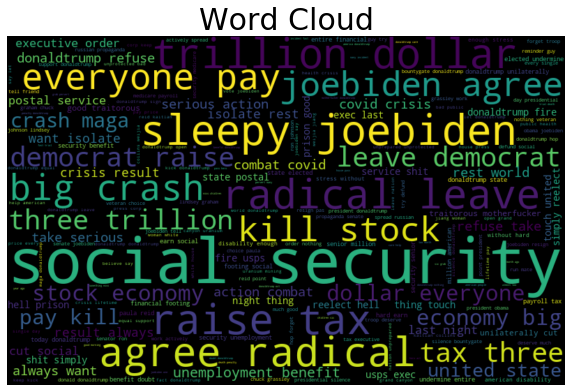

In [26]:
PlotWordCloud(all_words, 'Word Cloud')

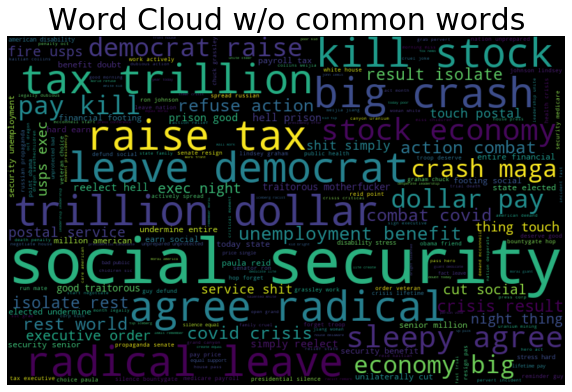

In [27]:
# temporarily remove some unwanted keywords, to get better view on text distribution
PlotWordCloud(all_words_filtered, 'Word Cloud w/o common words')

## Frequency Distribution of Tweets-Texts

Reference: https://github.com/ardhiraka/H8_SCL2020

Additional task: Identify irrelevant words (to add to stopwords)

Most frequent words
[('donaldtrump', 100482), ('joebiden', 62174), ('security', 28745), ('social', 28544), ('not', 26384), ('state', 19148), ('tax', 17312), ('get', 16403), ('president', 16138), ('benefit', 15112), ('american', 15026), ('good', 14558), ('democrat', 13939), ('leave', 13395), ('pay', 13372), ('but', 12834), ('crisis', 12755), ('take', 12409), ('want', 12089), ('today', 11547), ('big', 11332), ('economy', 11263), ('like', 11146), ('everyone', 10921), ('action', 10549), ('kill', 10500), ('say', 10237), ('maga', 10001), ('three', 9957), ('sleepy', 9953)]



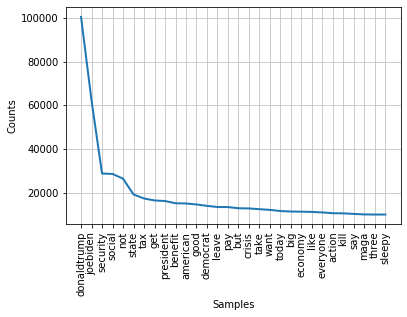

In [28]:
# Frequency Distribution of words
word_token = word_tokenize(all_words)

fdist = FreqDist(word_token)
print('Most frequent words')
print(fdist.most_common(30))
print()

fdist.plot(30, cumulative=False)
plt.show()

Most frequent words (filtered)
[('security', 28745), ('social', 28544), ('tax', 17312), ('benefit', 15112), ('american', 15026), ('good', 14558), ('democrat', 13939), ('leave', 13395), ('pay', 13372), ('crisis', 12755), ('today', 11547), ('big', 11332), ('economy', 11263), ('action', 10549), ('kill', 10500), ('state', 10177), ('maga', 10001), ('sleepy', 9953), ('agree', 9874), ('crash', 9792), ('radical', 9771), ('raise', 9742), ('thing', 9718), ('unemployment', 9671), ('dollar', 9630), ('stock', 9568), ('trillion', 9517), ('covid', 9379), ('cut', 9195), ('vote', 8809)]



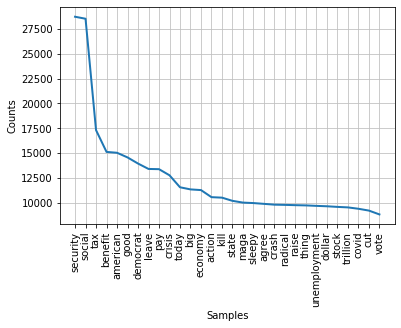

In [29]:
# remove common keywords, to get better view on text distribution
word_token = word_tokenize(all_words_filtered)

fdist = FreqDist(word_token)
print('Most frequent words (filtered)')
print(fdist.most_common(30))
print()

fdist.plot(30, cumulative=False)
plt.show()

# Sentiment Analysis

1. TextBlob
2. VADER

## TextBlob

Reference: https://textblob.readthedocs.io/en/dev/quickstart.html

In [31]:
# Run TextBlob on cleaned text to identify sentiment polarity
dftwit['textblobpolarity'] = dftwit['clean'].apply(lambda x: TextBlob(x).sentiment.polarity)

# identify sentiment index
dftwit['textblobpolarityindex'] = dftwit['textblobpolarity'].apply(lambda x: 1 if x>0 else (-1 if x<0 else 0))

In [32]:
# Results Overview: 
nTotalTwit = len(dftwit.index)
nTotalPosTwit = len(dftwit[dftwit['textblobpolarityindex']==1].index)
nTotalNegTwit = len(dftwit[dftwit['textblobpolarityindex']==-1].index)
nTotalNeuTwit = len(dftwit[dftwit['textblobpolarityindex']==0].index)
nBidenTwit = len(dftwit[dftwit['biden']==1].index)
nBidenPosTwit = len(dftwit[(dftwit['textblobpolarityindex']==1) & (dftwit['biden']==1)].index)
nBidenNegTwit = len(dftwit[(dftwit['textblobpolarityindex']==-1) & (dftwit['biden']==1)].index)
nBidenNeuTwit = len(dftwit[(dftwit['textblobpolarityindex']==0) & (dftwit['biden']==1)].index)
nTrumpTwit = len(dftwit[dftwit['trump']==1].index)
nTrumpPosTwit = len(dftwit[(dftwit['textblobpolarityindex']==1) & (dftwit['trump']==1)].index)
nTrumpNegTwit = len(dftwit[(dftwit['textblobpolarityindex']==-1) & (dftwit['trump']==1)].index)
nTrumpNeuTwit = len(dftwit[(dftwit['textblobpolarityindex']==0) & (dftwit['trump']==1)].index)

print('Sentiment Analysis using TextBlob:')
print()
print('Overall:')
print('Total Data:', nTotalTwit, '(',"{:.2%}".format(nTotalTwit/nTotalTwit),')' )
print('Positive:', nTotalPosTwit, '(',"{:.2%}".format(nTotalPosTwit/nTotalTwit),')' )
print('Negative:', nTotalNegTwit, '(',"{:.2%}".format(nTotalNegTwit/nTotalTwit),')' )
print('Neutral:', nTotalNeuTwit, '(',"{:.2%}".format(nTotalNeuTwit/nTotalTwit),')' )
print()
print('Biden:')
print('Total Data:', nBidenTwit, '(',"{:.2%}".format(nBidenTwit/nBidenTwit),')' )
print('Positive:', nBidenPosTwit, '(',"{:.2%}".format(nBidenPosTwit/nBidenTwit),')' )
print('Negative:', nBidenNegTwit, '(',"{:.2%}".format(nBidenNegTwit/nBidenTwit),')' )
print('Neutral:', nBidenNeuTwit, '(',"{:.2%}".format(nBidenNeuTwit/nBidenTwit),')' )
print()
print('Trump:')
print('Total Data:', nTrumpTwit, '(',"{:.2%}".format(nTrumpTwit/nTrumpTwit),')' )
print('Positive:', nTrumpPosTwit, '(',"{:.2%}".format(nTrumpPosTwit/nTrumpTwit),')' )
print('Negative:', nTrumpNegTwit, '(',"{:.2%}".format(nTrumpNegTwit/nTrumpTwit),')' )
print('Neutral:', nTrumpNeuTwit, '(',"{:.2%}".format(nTrumpNeuTwit/nTrumpTwit),')' )

Sentiment Analysis using TextBlob:

Overall:
Total Data: 144548 ( 100.00% )
Positive: 51243 ( 35.45% )
Negative: 49987 ( 34.58% )
Neutral: 43318 ( 29.97% )

Biden:
Total Data: 55246 ( 100.00% )
Positive: 18071 ( 32.71% )
Negative: 11997 ( 21.72% )
Neutral: 25178 ( 45.57% )

Trump:
Total Data: 89302 ( 100.00% )
Positive: 33172 ( 37.15% )
Negative: 37990 ( 42.54% )
Neutral: 18140 ( 20.31% )


## VADER

Journal Article: http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf

Reference: https://alphabold.com/sentiment-analysis-the-lexicon-based-approach/

Reference for Scoring: https://github.com/cjhutto/vaderSentiment#about-the-scoring


In [33]:
analyzer = SentimentIntensityAnalyzer()

polarity = []
polarity_index = []

for sentences in dftwit['clean']:

    ss = analyzer.polarity_scores(sentences)
    polarity.append(ss['compound'])
    
    if ss['compound'] >= 0.05 : 
        # Positive
        polarity_index.append(1)
    elif ss['compound'] <= -0.05 : 
        # Negative
        polarity_index.append(-1)
    else : 
        # Neutral
        polarity_index.append(0)


# Insert polarity into dataset
dftwit["vaderpolarity"] = polarity
dftwit["vaderpolarityindex"] = polarity_index

In [34]:
# Results Overview: 
oTotalTwit = len(dftwit.index)
oTotalPosTwit = len(dftwit[dftwit['vaderpolarityindex']==1].index)
oTotalNegTwit = len(dftwit[dftwit['vaderpolarityindex']==-1].index)
oTotalNeuTwit = len(dftwit[dftwit['vaderpolarityindex']==0].index)
oBidenTwit = len(dftwit[dftwit['biden']==1].index)
oBidenPosTwit = len(dftwit[(dftwit['vaderpolarityindex']==1) & (dftwit['biden']==1)].index)
oBidenNegTwit = len(dftwit[(dftwit['vaderpolarityindex']==-1) & (dftwit['biden']==1)].index)
oBidenNeuTwit = len(dftwit[(dftwit['vaderpolarityindex']==0) & (dftwit['biden']==1)].index)
oTrumpTwit = len(dftwit[dftwit['trump']==1].index)
oTrumpPosTwit = len(dftwit[(dftwit['vaderpolarityindex']==1) & (dftwit['trump']==1)].index)
oTrumpNegTwit = len(dftwit[(dftwit['vaderpolarityindex']==-1) & (dftwit['trump']==1)].index)
oTrumpNeuTwit = len(dftwit[(dftwit['vaderpolarityindex']==0) & (dftwit['trump']==1)].index)

print('Sentiment Analysis using TextBlob:')
print()
print('Overall:')
print('Total Data:', oTotalTwit, '(',"{:.2%}".format(oTotalTwit/oTotalTwit),')' )
print('Positive:', oTotalPosTwit, '(',"{:.2%}".format(oTotalPosTwit/oTotalTwit),')' )
print('Negative:', oTotalNegTwit, '(',"{:.2%}".format(oTotalNegTwit/oTotalTwit),')' )
print('Neutral:', oTotalNeuTwit, '(',"{:.2%}".format(oTotalNeuTwit/oTotalTwit),')' )
print()
print('Biden:')
print('Total Data:', oBidenTwit, '(',"{:.2%}".format(oBidenTwit/oBidenTwit),')' )
print('Positive:', oBidenPosTwit, '(',"{:.2%}".format(oBidenPosTwit/oBidenTwit),')' )
print('Negative:', oBidenNegTwit, '(',"{:.2%}".format(oBidenNegTwit/oBidenTwit),')' )
print('Neutral:', oBidenNeuTwit, '(',"{:.2%}".format(oBidenNeuTwit/oBidenTwit),')' )
print()
print('Trump:')
print('Total Data:', oTrumpTwit, '(',"{:.2%}".format(oTrumpTwit/oTrumpTwit),')' )
print('Positive:', oTrumpPosTwit, '(',"{:.2%}".format(oTrumpPosTwit/oTrumpTwit),')' )
print('Negative:', oTrumpNegTwit, '(',"{:.2%}".format(oTrumpNegTwit/oTrumpTwit),')' )
print('Neutral:', oTrumpNeuTwit, '(',"{:.2%}".format(oTrumpNeuTwit/oTrumpTwit),')' )

Sentiment Analysis using TextBlob:

Overall:
Total Data: 144548 ( 100.00% )
Positive: 60352 ( 41.75% )
Negative: 62460 ( 43.21% )
Neutral: 21736 ( 15.04% )

Biden:
Total Data: 55246 ( 100.00% )
Positive: 18309 ( 33.14% )
Negative: 23739 ( 42.97% )
Neutral: 13198 ( 23.89% )

Trump:
Total Data: 89302 ( 100.00% )
Positive: 42043 ( 47.08% )
Negative: 38721 ( 43.36% )
Neutral: 8538 ( 9.56% )


# Result Visualization

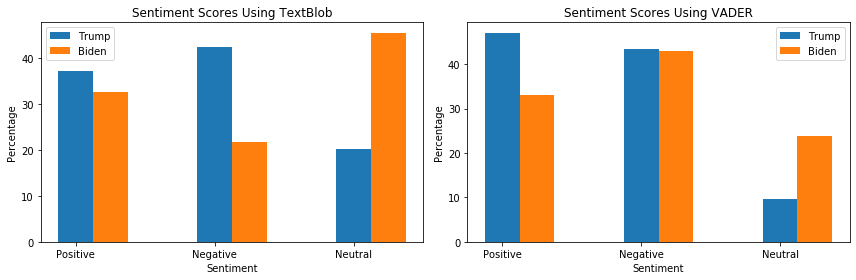

In [35]:
# BarChart

# data to plot

# TextBlob
dataTotal = (nTotalPosTwit/nTotalTwit*100, nTotalNegTwit/nTotalTwit*100, nTotalNeuTwit/nTotalTwit*100)
dataTrump = (nTrumpPosTwit/nTrumpTwit*100, nTrumpNegTwit/nTrumpTwit*100, nTrumpNeuTwit/nTrumpTwit*100)
dataBiden = (nBidenPosTwit/nBidenTwit*100, nBidenNegTwit/nBidenTwit*100, nBidenNeuTwit/nBidenTwit*100)

# Vader
dataTotal2 = (oTotalPosTwit/oTotalTwit*100, oTotalNegTwit/oTotalTwit*100, oTotalNeuTwit/oTotalTwit*100)
dataTrump2 = (oTrumpPosTwit/oTrumpTwit*100, oTrumpNegTwit/oTrumpTwit*100, oTrumpNeuTwit/oTrumpTwit*100)
dataBiden2 = (oBidenPosTwit/oBidenTwit*100, oBidenNegTwit/oBidenTwit*100, oBidenNeuTwit/oBidenTwit*100)


n_groups = 3
index = np.arange(n_groups)
bar_width = 0.25


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 4))

# TextBlob
#rects11 = ax1.bar(index, dataTotal, bar_width, label='Overall')
rects12 = ax1.bar(index + bar_width, dataTrump, bar_width, label='Trump')
rects13 = ax1.bar(index + (2*bar_width), dataBiden, bar_width, label='Biden')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_title('Sentiment Scores Using TextBlob')
ax1.set_xlabel('Sentiment')
ax1.set_ylabel('Percentage')
ax1.set_xticks(index+bar_width)
ax1.set_xticklabels(('Positive', 'Negative', 'Neutral'))
ax1.legend()


# Vader
#rects21 = ax2.bar(index, dataTotal2, bar_width, label='Overall')
rects22 = ax2.bar(index + bar_width, dataTrump2, bar_width, label='Trump')
rects23 = ax2.bar(index + (2*bar_width), dataBiden2, bar_width, label='Biden')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_title('Sentiment Scores Using VADER')
ax2.set_xlabel('Sentiment')
ax2.set_ylabel('Percentage')
ax2.set_xticks(index+bar_width)
ax2.set_xticklabels(('Positive', 'Negative', 'Neutral'))
ax2.legend()


fig.tight_layout()
plt.show()

# Bigrams

Explore top bigrams for both positive and negative sentiments

In [36]:
# Function to generate n-grams
def generate_Ngrams(reviews, num=2):
    token = word_tokenize(reviews)
    ngram = ngrams(token, num)
    return ngram

In [37]:
def plotMostCommonWords(reviews_counter,title="Common Review Words",color="blue",axis=None):
    data=pd.DataFrame()
    data['words']=[val[0] for val in reviews_counter]
    data['freq']=[val[1] for val in reviews_counter]
    if axis!=None:
        sns.barplot(y='words',x='freq',data=data,color=color,ax=axis).set_title(title)
    else:
        sns.barplot(y='words',x='freq',data=data,color=color).set_title(title)

In [38]:
# identify list of texts with positive and negative sentiment
# posSentiment = dftwit[dftwit.vaderpolarityindex == 1]['clean']
# negSentiment = dftwit[dftwit.vaderpolarityindex == -1]['clean'] 

# get positive words (exclude common words)
posWords = ' '.join([text for text in dftwit[dftwit.vaderpolarityindex == 1]['clean']])
posWords = re.sub('|'.join(r"(?<=\s){}(?=\s)".format(i) for i in common_words), '', " "+posWords+" ")

# get negative words (exclude common words)
negWords = ' '.join([text for text in dftwit[dftwit.vaderpolarityindex == -1]['clean']])
negWords = re.sub('|'.join(r"(?<=\s){}(?=\s)".format(i) for i in common_words), '', " "+negWords+" ")

In [39]:
posBigram = generate_Ngrams(posWords, 2)
negBigram = generate_Ngrams(negWords, 2)
top20posBigram = collections.Counter(posBigram).most_common(20)
top20negBigram = collections.Counter(negBigram).most_common(20)

In [40]:
# top20posBigram

In [41]:
# top20negBigram

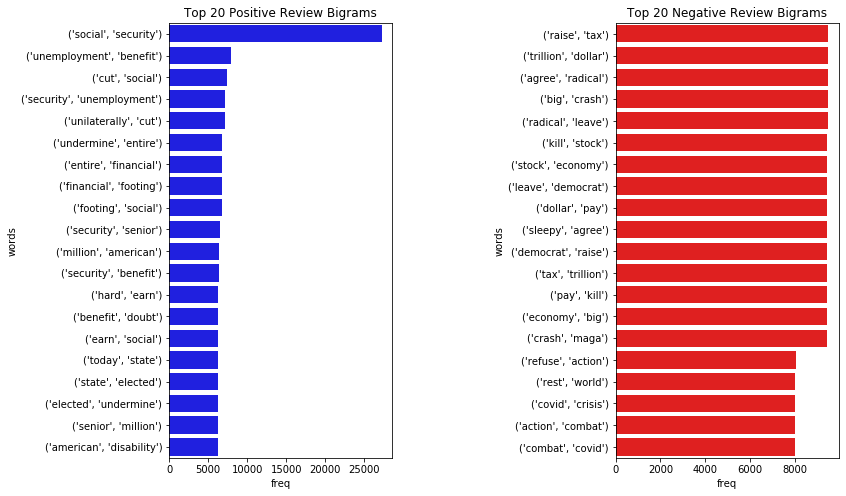

In [42]:
fig,ax=plt.subplots(1,2, figsize=(12,8))
fig.subplots_adjust(wspace=1) #Adjusts the space between the two plots
plotMostCommonWords(top20posBigram,"Top 20 Positive Review Bigrams",axis=ax[0])
plotMostCommonWords(top20negBigram,"Top 20 Negative Review Bigrams",color="red",axis=ax[1])

# Topic Modelling

Reference: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

Reference (LDA): https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

Reference (LDA Coherence): https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

### Preparing texts for Topic Modelling:

- Removing common English words 
- Tokenize each text into list 
- Combining all tokens to create a stream

In [47]:
def prepare_text_for_lda(text):
    tokens = word_tokenize(text)
    #tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in common_words]
    return tokens

### Evaluating the Appropriate Number of Topics using Coherence Model

For simplicity, choose optimum topic between 3 and 10, with highest coherence score



In [51]:
def evaluate_graph(dictionary, corpus, texts, limit):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.title("Coherence Model to determine the appropriate number of Topics")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v

### Generate the LDA Model


In [54]:
Lda = gensim.models.ldamodel.LdaModel

In [58]:
# Prepare texts for LDA 
dftwit['ldatokens'] = dftwit['clean'].apply(lambda x: prepare_text_for_lda(x))
word_stream2 = dftwit['ldatokens'].to_list()
dictionary2 = corpora.Dictionary(word_stream2)
doc_term_matrix2 = [dictionary2.doc2bow(doc) for doc in word_stream2]

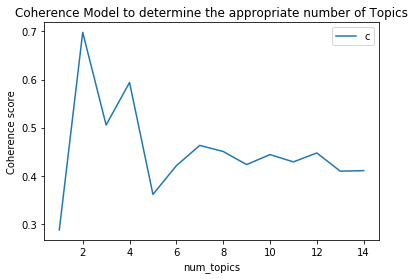

Wall time: 7min 41s


In [59]:
%%time
# get Optimal number of Topic
lmlist2, c_v2 = evaluate_graph(dictionary=dictionary2, corpus=doc_term_matrix2, texts=word_stream2, limit=15)

In [60]:
%%time
# Preparing LDA Model for Display 
optimalTopic2 = c_v2.index(max(c_v2[2:10])) + 1
print('Optimal Topic:', optimalTopic2)
ldamodel2 = Lda(doc_term_matrix2, num_topics = optimalTopic2, id2word = dictionary2, passes=5)
lda_display2 = pyLDAvis.gensim.prepare(ldamodel2, doc_term_matrix2, dictionary2, sort_topics=False)
pyLDAvis.display(lda_display2)

Optimal Topic: 4
Wall time: 4min 22s


C:\Users\ngwei\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [61]:
# # Saving model in HTML file
pyLDAvis.save_html(lda_display2, 'static/'+datetime.strftime(varDate, '%m%d%Y')+'twit.html')

In [62]:
twitEndTime = time.time() - starttime

# Part2: Reddit Data
- Read from MongoDB
- Data Cleaning
- Run Sentiment Analysis
- Perform Topic Modelling

In [63]:
# Reddit
starttime = time.time()

In [64]:
%%time 

# Access Twitter Collection in MongoDB 
mongo_collection = mongo_db['fypreddit']

# reference: https://stackoverflow.com/questions/26366417/how-to-make-a-query-date-in-mongodb-using-pymongo
start = time.mktime(datetime(varYr, varMonth, varDay, 0, 0, 1).timetuple()) + 43200
end = time.mktime(datetime(varYr, varMonth, varDay, 23, 59, 59).timetuple()) + 43200
# Note: Time-displacement 12 hours. Washington DC is UTC-4, but in fact Reddit data stored in UTC+8 time (local PC)


dfredd = pd.DataFrame(list(mongo_collection.find( {'created_at': {'$lt': end, '$gte': start}})))

Wall time: 19.2 s


### Drop bot messages (auto-posted by moderators)

In [65]:
# DROP bot messages

def checkbot(text):
    botmsg = "I am a bot, and this action was performed automatically"
    botmsg = ["I am a bot, and this action was performed automatically", "I'm a bot", "The following is an automated message", "If you have any questions about this removal", "has been removed for the following reason"]
    return 1 if any(keyword in text for keyword in botmsg) else 0

dfredd['botmsg'] = dfredd['text'].apply(lambda x: checkbot(x))
dfredd = dfredd.drop(dfredd[(dfredd['botmsg']==1)].index)

#### Convert Timestamp and retain time / text column

In [66]:
# Convert Unix Timestamp to DateTime format, adjust back to UTC-4 (Washington-DC time)
dfredd['created_at'] = dfredd['created_at'].apply(lambda x: datetime.fromtimestamp(x-43200))

# drop other columns, keep only timestamp and text
dfredd = dfredd[['created_at', 'text']]

### Initial EDA


In [67]:
# # Number of Words
# dfredd['word_count'] = dfredd['text'].apply(lambda x: len(str(x).split(" ")))

# # Number of Character
# dfredd['char_count'] = dfredd['text'].str.len()

# # Number of hashtags
# dfredd['hashtag'] = dfredd['text'].str.count("#")

# # Number of mentions
# dfredd['mention'] = dfredd['text'].str.count("@")

# # Number of URLs
# dfredd['url'] = dfredd['text'].str.count('http')

In [68]:
# dfredd[['word_count', 'char_count', 'hashtag', 'mention', 'url']].describe()

In [69]:
# # Distribution of Word-Count (Text)
# plt.figure(dpi = 120)
# sns.distplot(dfredd.word_count, hist=False, color = 'green')

In [70]:
# # Closer look at the extreme values 

# dfredd[['word_count', 'char_count', 'hashtag', 'mention', 'url']].describe([0.005, 0.05, 0.1, 0.15, 0.95, 0.99, 0.992, 0.995])

### Text Preprocessing (Reddit)

1. Converting texts to lower case
2. Replacing Negation keywords
3. Removing URLs
4. Removing Tagging / Mentions / Hashtag
5. Removing single-char words
6. Replacing Target keywords
7. Removing punctuations | numerical values | non-English characters
8. Keeping Emoji | Alphabets
9. Removing stop words
10. Tokenize text
11. Part of Speech (POS) tagging 
12. Lemmatization

### ReGex text patterns
Reference: https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b

keep a-z A-Z and Emojis

remove numbers, punctuations, special languages (eg Chinese Russian Hindi)


In [71]:
text_pattern = re.compile("[^"
        u"a-zA-Z"                 # alphabets
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        #u"\U0001F680-\U0001F6FF"  # transport & map symbols
        #u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        #u"\U00002500-\U00002BEF"
        #u"\U000024C2-\U0001F251"  # chinese / asian char
        u"\U00002702-\U000027B0"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
        "]+", flags=re.UNICODE)


### Stop Words

Base dictionary from Kaggle Dataset
- Reference: https://www.kaggle.com/rtatman/stopword-lists-for-19-languages?select=englishST.txt

Append additional stopwords

Remove negation keywords from dictionary (crucial for sentiment analysis)

In [72]:
# StopWords

# (NLTK English corpus)
stop_words = stopwords.words("english")

# Using Kaggle stopwords dataset
# tmp = pd.read_csv(r'C:\Users\ngwei\Dropbox\UM_Master\UM_FYP\FYP_Docs\MYenglishST.txt', header=None, names=['list'])
# stop_words = tmp['list'].tolist()

# Manually adding keywords to list of stopwords
addstopwords = ['reddit', 'subreddit']
stop_words.extend(addstopwords)

# Remove certain keywords from dictionary
removestopwords = ['not', 'but', 'believe', 'certainly', 'clearly', 'consequently', 'definitely', 'downwards', 'entirely', 'especially', 'exactly', 'except', 'hardly', 'hence', 'hopefully', 'however', 'immediate', 'inasmuch', 'indeed', 'insofar', 'least', 'less', 'merely', 'more', 'moreover', 'most', 'mostly', 'much', 'must', 'necessary', 'obviously', 'otherwise', 'particular', 'particularly', 'perhaps', 'possible', 'probably', 'presumably', 'reasonably', 'regardless', 'relatively', 'serious', 'seriously', 'sure', 'thorough', 'thoroughly', 'truly', 'unfortunately', 'unless', 'unlikely', 'useful']
stop_words = [ele for ele in stop_words if ele not in removestopwords]

# print(stop_words)

### Replacing target-specific keywords

Standardize related keywords

In [73]:
# Standardize and Replace specific keywords

# donaldtrump
keyTrump = {'donald trump', '#trump', 'trump', 'trumps', '#donaldtrump'} 

# joebiden
keyBiden = {'joe biden', 'biden', "#joebiden", '#biden'} 

# negation keywords
keyNegation = {'never', 'not', 'no', 'nor', 'non', 'none', "isn't", "isnt", "wasn't", "wasnt", "weren't", "ain't", "aren't", "don't", 'dont', 'doesnt', "doesn't", "didn't", 'dint', "hadn't", "hasn't", "haven't", "shouldn't", 'shouldnt', "can't", 'cannot', 'cant', "couldn't"}

### POS-Tagging and Lemmatization

In [74]:
# Declare Lemmatizer from NLTK Library
wordnet_lemmatizer = WordNetLemmatizer()
# Ref: https://www.machinelearningplus.com/nlp/lemmatization-examples-python/

# Declare Tokenizer from NLTK Library
TweetTokeniser = TweetTokenizer()

# POS-Tagging
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# Lemmatization
def lemmatize_sentence(wordlist):
    # find the POS tag for each token
    nltk_tagged = nltk.pos_tag(wordlist)
    # tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(wordnet_lemmatizer.lemmatize(word, tag))
    return (" ".join(lemmatized_sentence)).strip()

### Summary: Function to clean reddit texts

In [75]:
# Functions to clean twitter texts
def text_cleaner(text):
    
    # convert all texts to lower case
    text = text.lower()
    
    # Replace trump / biden keywords
    text = re.sub('|'.join(r"(?<=\s){}(?=\b)".format(i) for i in keyTrump), 'donaldtrump', " "+text+" ")    
    text = re.sub('|'.join(r"(?<=\s){}(?=\b)".format(i) for i in keyBiden), 'joebiden', " "+text+" ")

    # replace keywords: negation
    text = re.sub('|'.join(r"(?<=\s){}(?=\b)".format(i) for i in keyNegation), 'not', " "+text+" ")
    
    # unescaping HTML changing '&amp;' to 'and'
    text = text.replace('&amp;','and')
    
    # remove URLs
    text = re.sub('https?://[A-Za-z0-9./&%=?-_]+','',text)

    # Remove Mention / Tagging
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    
    # text pattern: keeping Emoji and English-Alphabets, removing punctuations and non-English language characters
    # hashtags to be kept, only removing # symbols
    text = re.sub(text_pattern, " ", text)

    # remove single character words
    text = re.sub(r'\b\w{1}\b', '', text)

    # ASSERT: Replace trump / biden keywords
    text = re.sub('|'.join(r"(?<=\s){}(?=\b)".format(i) for i in keyTrump), 'donaldtrump', " "+text+" ")    
    text = re.sub('|'.join(r"(?<=\s){}(?=\b)".format(i) for i in keyBiden), 'joebiden', " "+text+" ")
    
    # Tokenization
    textlist = TweetTokeniser.tokenize(text)
    
    # Removing stop-words
    textlist = [word for word in textlist if word not in stop_words]
    
    # Lemmatization & POS-Tagging
    text = lemmatize_sentence(textlist)

    return text

### Pre-Process Raw Texts to get Clean Text

In [76]:
%%time

# Show progress bar
#for i in progressbar(range(15), "Computing: ", 40):
dfredd['clean'] = dfredd['text'].apply(text_cleaner)


Wall time: 1min 31s


## Identify Target (for Stance Analysis)
- Donald Trump
- Joe Biden

In [77]:
dfredd['trump'] = dfredd['clean'].apply(lambda x: 1 if 'donaldtrump' in x else 0)
dfredd['biden'] = dfredd['clean'].apply(lambda x: 1 if 'joebiden' in x else 0)

nTotal = len(dfredd.index)
nTrump = dfredd['trump'].sum()
nBiden = dfredd['biden'].sum()
nBoth = len(dfredd[(dfredd['trump']==1) & (dfredd['biden']==1)].index)
nNone = len(dfredd[(dfredd['trump']==0) & (dfredd['biden']==0)].index)

print('Total Data:', nTotal, '(',"{:.2%}".format(nTotal/nTotal),')' )
print('Contains Trump:', nTrump, '(',"{:.2%}".format(nTrump/nTotal),')' )
print('Contains Biden:', nBiden, '(',"{:.2%}".format(nBiden/nTotal),')' )
print('Contains both:', nBoth, '(',"{:.2%}".format(nBoth/nTotal),')' )
print('Contains none:', nNone, '(',"{:.2%}".format(nNone/nTotal),')' )

Total Data: 33383 ( 100.00% )
Contains Trump: 27297 ( 81.77% )
Contains Biden: 8227 ( 24.64% )
Contains both: 3341 ( 10.01% )
Contains none: 1200 ( 3.59% )


As the percentage of data containing both / no targets are considerably low (~10%)

For simplicity's sake, consider only data with ONLY ONE target 

In [78]:
dfredd = dfredd.drop(dfredd[(dfredd['trump']==1) & (dfredd['biden']==1)].index)
dfredd = dfredd.drop(dfredd[(dfredd['trump']==0) & (dfredd['biden']==0)].index)

# ASSERT
nTotal = len(dfredd.index)
nTrump = dfredd['trump'].sum()
nBiden = dfredd['biden'].sum()
nBoth = len(dfredd[(dfredd['trump']==1) & (dfredd['biden']==1)].index)
nNone = len(dfredd[(dfredd['trump']==0) & (dfredd['biden']==0)].index)

print('Total Data:', nTotal, '(',"{:.2%}".format(nTotal/nTotal),')' )
print('Contains Trump:', nTrump, '(',"{:.2%}".format(nTrump/nTotal),')' )
print('Contains Biden:', nBiden, '(',"{:.2%}".format(nBiden/nTotal),')' )
print('Contains both:', nBoth, '(',"{:.2%}".format(nBoth/nTotal),')' )
print('Contains none:', nNone, '(',"{:.2%}".format(nNone/nTotal),')' )

Total Data: 28842 ( 100.00% )
Contains Trump: 23956 ( 83.06% )
Contains Biden: 4886 ( 16.94% )
Contains both: 0 ( 0.00% )
Contains none: 0 ( 0.00% )


### Remove Outliers 

- Consider only data with Word_Counts <= 200
- Consider only data with Word_Counts >= 3 words, for better literacy / accuracy
- Consider only data with char_count <= 1000

In [79]:
# Number of Words (cleaned text)
dfredd['word_count'] = dfredd['clean'].apply(lambda x: len(str(x).split(" ")))

# Number of Character (cleaned text)
dfredd['char_count'] = dfredd['clean'].str.len()

# # Number of stopwords (raw text)
# dfredd['stopwords'] = dfredd['text'].apply(lambda x: len([x for x in x.split() if x.lower() in stop_words]))

In [80]:
# dfredd[['word_count', 'char_count', 'stopwords']].describe([0.005, 0.05, 0.1, 0.15, 0.95, 0.99, 0.992, 0.995])

In [81]:
dfredd = dfredd[dfredd['word_count']<=500]
dfredd = dfredd[dfredd['word_count']>=3]
dfredd = dfredd[dfredd['char_count']<=2500]

# dfredd[['word_count', 'char_count', 'stopwords']].describe()

### Data Visualization

In [82]:
# # Distribution of Word-Count (Cleaned Text)
# plt.figure(dpi = 120)
# sns.distplot(dfredd.word_count, hist=False, color = 'green')

In [83]:
# # Distribution of Stopwords-Count
# plt.figure(dpi = 120)
# sns.distplot(dfredd.stopwords, hist=False, color = 'green')

### WordCloud
Reference: https://www.analyticsvidhya.com/blog/2018/07/hands-on-sentiment-analysis-dataset-python/

In [84]:
# Get list of words 
all_words = ' '.join([text for text in dfredd['clean']])
all_words_filtered = re.sub('|'.join(r"(?<=\s){}(?=\b)".format(i) for i in common_words), '', " "+all_words+" ")

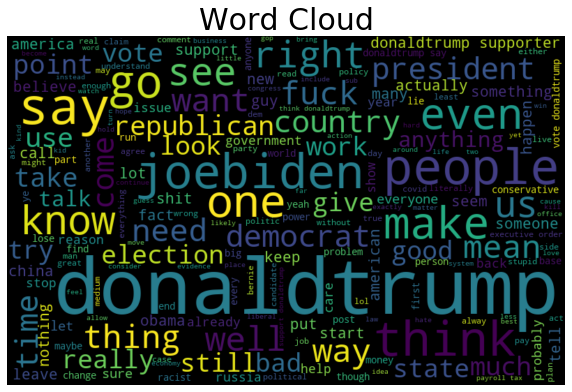

In [85]:
PlotWordCloud(all_words, 'Word Cloud')

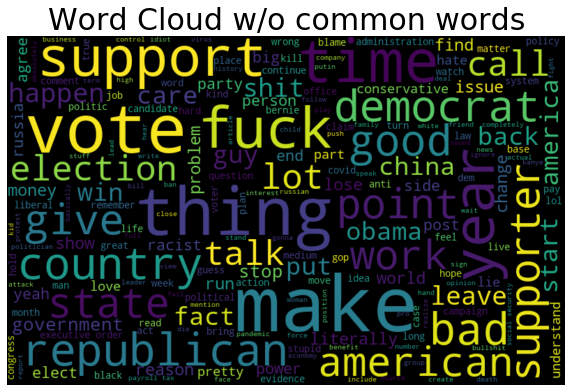

In [86]:
# temporarily remove some unwanted keywords, to get better view on text distribution
PlotWordCloud(all_words_filtered, 'Word Cloud w/o common words')

### Frequency Distribution of Tweets-Texts

Reference: https://github.com/ardhiraka/H8_SCL2020

Additional task: Identify irrelevant words (to add to stopwords)

Most frequent words
[('donaldtrump', 29781), ('not', 27081), ('but', 9432), ('people', 7776), ('say', 6989), ('like', 6392), ('get', 6254), ('joebiden', 5675), ('would', 5238), ('go', 5208), ('think', 5072), ('make', 4719), ('vote', 4545), ('more', 4080), ('one', 3927), ('know', 3501), ('even', 3496), ('want', 3475), ('right', 3188), ('thing', 3072), ('us', 3048), ('see', 2974), ('time', 2631), ('president', 2605), ('take', 2586), ('year', 2448), ('election', 2447), ('also', 2384), ('bad', 2353), ('good', 2337)]



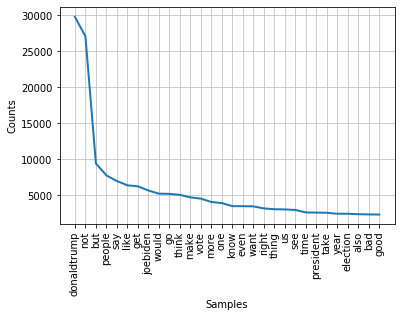

In [87]:
# Frequency Distribution of words
word_token = word_tokenize(all_words)

fdist = FreqDist(word_token)
print('Most frequent words')
print(fdist.most_common(30))
print()

fdist.plot(30, cumulative=False)
plt.show()

Most frequent words (filtered)
[('make', 4719), ('vote', 4545), ('thing', 3072), ('time', 2631), ('year', 2448), ('election', 2447), ('bad', 2353), ('good', 2337), ('fuck', 2273), ('country', 2086), ('state', 2047), ('american', 1938), ('support', 1919), ('give', 1871), ('work', 1867), ('democrat', 1834), ('point', 1685), ('republican', 1669), ('shit', 1594), ('win', 1541), ('call', 1540), ('supporter', 1487), ('tax', 1484), ('back', 1481), ('china', 1480), ('leave', 1465), ('talk', 1425), ('russia', 1333), ('happen', 1333), ('money', 1332)]



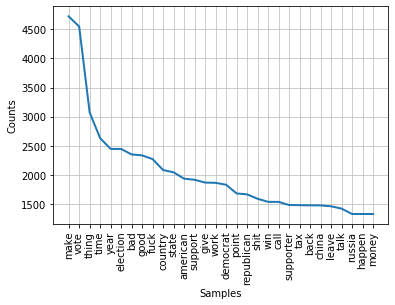

In [88]:
# Frequency Distribution of words
# remove common keywords, to get better view on text distribution
word_token = word_tokenize(all_words_filtered)

fdist = FreqDist(word_token)
print('Most frequent words (filtered)')
print(fdist.most_common(30))
print()

fdist.plot(30, cumulative=False)
plt.show()

# Sentiment Analysis

1. TextBlob
2. VADER

### TextBlob

Reference: https://textblob.readthedocs.io/en/dev/quickstart.html

In [89]:
# Run TextBlob on cleaned text to identify sentiment polarity
dfredd['textblobpolarity'] = dfredd['clean'].apply(lambda x: TextBlob(x).sentiment.polarity)

# identify sentiment index
dfredd['textblobpolarityindex'] = dfredd['textblobpolarity'].apply(lambda x: 1 if x>0 else (-1 if x<0 else 0))

In [90]:
# Results Overview: 
nTotalRedd = len(dfredd.index)
nTotalPosRedd = len(dfredd[dfredd['textblobpolarityindex']==1].index)
nTotalNegRedd = len(dfredd[dfredd['textblobpolarityindex']==-1].index)
nTotalNeuRedd = len(dfredd[dfredd['textblobpolarityindex']==0].index)
nBidenRedd = len(dfredd[dfredd['biden']==1].index)
nBidenPosRedd = len(dfredd[(dfredd['textblobpolarityindex']==1) & (dfredd['biden']==1)].index)
nBidenNegRedd = len(dfredd[(dfredd['textblobpolarityindex']==-1) & (dfredd['biden']==1)].index)
nBidenNeuRedd = len(dfredd[(dfredd['textblobpolarityindex']==0) & (dfredd['biden']==1)].index)
nTrumpRedd = len(dfredd[dfredd['trump']==1].index)
nTrumpPosRedd = len(dfredd[(dfredd['textblobpolarityindex']==1) & (dfredd['trump']==1)].index)
nTrumpNegRedd = len(dfredd[(dfredd['textblobpolarityindex']==-1) & (dfredd['trump']==1)].index)
nTrumpNeuRedd = len(dfredd[(dfredd['textblobpolarityindex']==0) & (dfredd['trump']==1)].index)

print('Sentiment Analysis using TextBlob:')
print()
print('Overall:')
print('Total Data:', nTotalRedd, '(',"{:.2%}".format(nTotalRedd/nTotalRedd),')' )
print('Positive:', nTotalPosRedd, '(',"{:.2%}".format(nTotalPosRedd/nTotalRedd),')' )
print('Negative:', nTotalNegRedd, '(',"{:.2%}".format(nTotalNegRedd/nTotalRedd),')' )
print('Neutral:', nTotalNeuRedd, '(',"{:.2%}".format(nTotalNeuRedd/nTotalRedd),')' )
print()
print('Biden:')
print('Total Data:', nBidenRedd, '(',"{:.2%}".format(nBidenRedd/nBidenRedd),')' )
print('Positive:', nBidenPosRedd, '(',"{:.2%}".format(nBidenPosRedd/nBidenRedd),')' )
print('Negative:', nBidenNegRedd, '(',"{:.2%}".format(nBidenNegRedd/nBidenRedd),')' )
print('Neutral:', nBidenNeuRedd, '(',"{:.2%}".format(nBidenNeuRedd/nBidenRedd),')' )
print()
print('Trump:')
print('Total Data:', nTrumpRedd, '(',"{:.2%}".format(nTrumpRedd/nTrumpRedd),')' )
print('Positive:', nTrumpPosRedd, '(',"{:.2%}".format(nTrumpPosRedd/nTrumpRedd),')' )
print('Negative:', nTrumpNegRedd, '(',"{:.2%}".format(nTrumpNegRedd/nTrumpRedd),')' )
print('Neutral:', nTrumpNeuRedd, '(',"{:.2%}".format(nTrumpNeuRedd/nTrumpRedd),')' )

Sentiment Analysis using TextBlob:

Overall:
Total Data: 28077 ( 100.00% )
Positive: 13827 ( 49.25% )
Negative: 8743 ( 31.14% )
Neutral: 5507 ( 19.61% )

Biden:
Total Data: 4732 ( 100.00% )
Positive: 2485 ( 52.51% )
Negative: 1243 ( 26.27% )
Neutral: 1004 ( 21.22% )

Trump:
Total Data: 23345 ( 100.00% )
Positive: 11342 ( 48.58% )
Negative: 7500 ( 32.13% )
Neutral: 4503 ( 19.29% )


## VADER

Journal Article: http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf

Reference for Scoring: https://github.com/cjhutto/vaderSentiment#about-the-scoring

In [91]:
analyzer = SentimentIntensityAnalyzer()

polarity = []
polarity_index = []

for sentences in dfredd['clean']:

    ss = analyzer.polarity_scores(sentences)
    polarity.append(ss['compound'])
    
    if ss['compound'] >= 0.05 : 
        # Positive
        polarity_index.append(1)
    elif ss['compound'] <= -0.05 : 
        # Negative
        polarity_index.append(-1)
    else : 
        # Neutral
        polarity_index.append(0)


# Insert polarity into dataset
dfredd["vaderpolarity"] = polarity
dfredd["vaderpolarityindex"] = polarity_index

In [92]:
# Results Overview: 
oTotalRedd = len(dfredd.index)
oTotalPosRedd = len(dfredd[dfredd['vaderpolarityindex']==1].index)
oTotalNegRedd = len(dfredd[dfredd['vaderpolarityindex']==-1].index)
oTotalNeuRedd = len(dfredd[dfredd['vaderpolarityindex']==0].index)
oBidenRedd = len(dfredd[dfredd['biden']==1].index)
oBidenPosRedd = len(dfredd[(dfredd['vaderpolarityindex']==1) & (dfredd['biden']==1)].index)
oBidenNegRedd = len(dfredd[(dfredd['vaderpolarityindex']==-1) & (dfredd['biden']==1)].index)
oBidenNeuRedd = len(dfredd[(dfredd['vaderpolarityindex']==0) & (dfredd['biden']==1)].index)
oTrumpRedd = len(dfredd[dfredd['trump']==1].index)
oTrumpPosRedd = len(dfredd[(dfredd['vaderpolarityindex']==1) & (dfredd['trump']==1)].index)
oTrumpNegRedd = len(dfredd[(dfredd['vaderpolarityindex']==-1) & (dfredd['trump']==1)].index)
oTrumpNeuRedd = len(dfredd[(dfredd['vaderpolarityindex']==0) & (dfredd['trump']==1)].index)

print('Sentiment Analysis using TextBlob:')
print()
print('Overall:')
print('Total Data:', oTotalRedd, '(',"{:.2%}".format(oTotalRedd/oTotalRedd),')' )
print('Positive:', oTotalPosRedd, '(',"{:.2%}".format(oTotalPosRedd/oTotalRedd),')' )
print('Negative:', oTotalNegRedd, '(',"{:.2%}".format(oTotalNegRedd/oTotalRedd),')' )
print('Neutral:', oTotalNeuRedd, '(',"{:.2%}".format(oTotalNeuRedd/oTotalRedd),')' )
print()
print('Biden:')
print('Total Data:', oBidenRedd, '(',"{:.2%}".format(oBidenRedd/oBidenRedd),')' )
print('Positive:', oBidenPosRedd, '(',"{:.2%}".format(oBidenPosRedd/oBidenRedd),')' )
print('Negative:', oBidenNegRedd, '(',"{:.2%}".format(oBidenNegRedd/oBidenRedd),')' )
print('Neutral:', oBidenNeuRedd, '(',"{:.2%}".format(oBidenNeuRedd/oBidenRedd),')' )
print()
print('Trump:')
print('Total Data:', oTrumpRedd, '(',"{:.2%}".format(oTrumpRedd/oTrumpRedd),')' )
print('Positive:', oTrumpPosRedd, '(',"{:.2%}".format(oTrumpPosRedd/oTrumpRedd),')' )
print('Negative:', oTrumpNegRedd, '(',"{:.2%}".format(oTrumpNegRedd/oTrumpRedd),')' )
print('Neutral:', oTrumpNeuRedd, '(',"{:.2%}".format(oTrumpNeuRedd/oTrumpRedd),')' )

Sentiment Analysis using TextBlob:

Overall:
Total Data: 28077 ( 100.00% )
Positive: 12173 ( 43.36% )
Negative: 12150 ( 43.27% )
Neutral: 3754 ( 13.37% )

Biden:
Total Data: 4732 ( 100.00% )
Positive: 2163 ( 45.71% )
Negative: 1770 ( 37.40% )
Neutral: 799 ( 16.89% )

Trump:
Total Data: 23345 ( 100.00% )
Positive: 10010 ( 42.88% )
Negative: 10380 ( 44.46% )
Neutral: 2955 ( 12.66% )


# Result Visualization

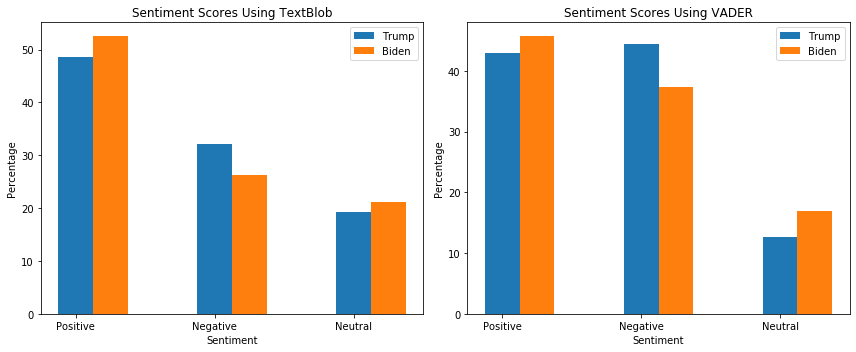

In [93]:
# BarChart

# data to plot

# TextBlob
dataTotal = (nTotalPosRedd/nTotalRedd*100, nTotalNegRedd/nTotalRedd*100, nTotalNeuRedd/nTotalRedd*100)
dataTrump = (nTrumpPosRedd/nTrumpRedd*100, nTrumpNegRedd/nTrumpRedd*100, nTrumpNeuRedd/nTrumpRedd*100)
dataBiden = (nBidenPosRedd/nBidenRedd*100, nBidenNegRedd/nBidenRedd*100, nBidenNeuRedd/nBidenRedd*100)

# Vader
dataTotal2 = (oTotalPosRedd/oTotalRedd*100, oTotalNegRedd/oTotalRedd*100, oTotalNeuRedd/oTotalRedd*100)
dataTrump2 = (oTrumpPosRedd/oTrumpRedd*100, oTrumpNegRedd/oTrumpRedd*100, oTrumpNeuRedd/oTrumpRedd*100)
dataBiden2 = (oBidenPosRedd/oBidenRedd*100, oBidenNegRedd/oBidenRedd*100, oBidenNeuRedd/oBidenRedd*100)


n_groups = 3
index = np.arange(n_groups)
bar_width = 0.25


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 5))

# TextBlob
#rects11 = ax1.bar(index, dataTotal, bar_width, label='Overall')
rects12 = ax1.bar(index + bar_width, dataTrump, bar_width, label='Trump')
rects13 = ax1.bar(index + (2*bar_width), dataBiden, bar_width, label='Biden')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_title('Sentiment Scores Using TextBlob')
ax1.set_xlabel('Sentiment')
ax1.set_ylabel('Percentage')
ax1.set_xticks(index+bar_width)
ax1.set_xticklabels(('Positive', 'Negative', 'Neutral'))
ax1.legend()


# Vader
#rects21 = ax2.bar(index, dataTotal2, bar_width, label='Overall')
rects22 = ax2.bar(index + bar_width, dataTrump2, bar_width, label='Trump')
rects23 = ax2.bar(index + (2*bar_width), dataBiden2, bar_width, label='Biden')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_title('Sentiment Scores Using VADER')
ax2.set_xlabel('Sentiment')
ax2.set_ylabel('Percentage')
ax2.set_xticks(index+bar_width)
ax2.set_xticklabels(('Positive', 'Negative', 'Neutral'))
ax2.legend()


fig.tight_layout()
plt.show()

# Bigrams

Explore top bigrams for both positive and negative sentiments

In [94]:
# Exclude Common Words in Reddit

# Manually adding keywords to list of stopwords
addstopwords = ['gon na', 'fox news', 'republican party', 'democratic party', 'social medium', 'white house']
common_words.extend(addstopwords)

# Remove certain keywords from dictionary
# removestopwords = ['not', 'but', 'believe', 'certainly', 'clearly', 'consequently', 'definitely', 'downwards', 'entirely', 'especially', 'exactly', 'except', 'hardly', 'hence', 'hopefully', 'however', 'immediate', 'inasmuch', 'indeed', 'insofar', 'least', 'less', 'merely', 'more', 'moreover', 'most', 'mostly', 'much', 'must', 'necessary', 'obviously', 'otherwise', 'particular', 'particularly', 'perhaps', 'possible', 'probably', 'presumably', 'reasonably', 'regardless', 'relatively', 'serious', 'seriously', 'sure', 'thorough', 'thoroughly', 'truly', 'unfortunately', 'unless', 'unlikely', 'useful']
# common_words = [ele for ele in common_words if ele not in removestopwords]

# print(common_words)

In [95]:
# get positive words (exclude common words)
posWords = ' '.join([text for text in dfredd[dfredd.vaderpolarityindex == 1]['clean']])
posWords = re.sub('|'.join(r"(?<=\s){}(?=\s)".format(i) for i in common_words), '', " "+posWords+" ")

# get negative words (exclude common words)
negWords = ' '.join([text for text in dfredd[dfredd.vaderpolarityindex == -1]['clean']])
negWords = re.sub('|'.join(r"(?<=\s){}(?=\s)".format(i) for i in common_words), '', " "+negWords+" ")

In [96]:
posBigram = generate_Ngrams(posWords, 2)
negBigram = generate_Ngrams(negWords, 2)
top20posBigram = collections.Counter(posBigram).most_common(20)
top20negBigram = collections.Counter(negBigram).most_common(20)

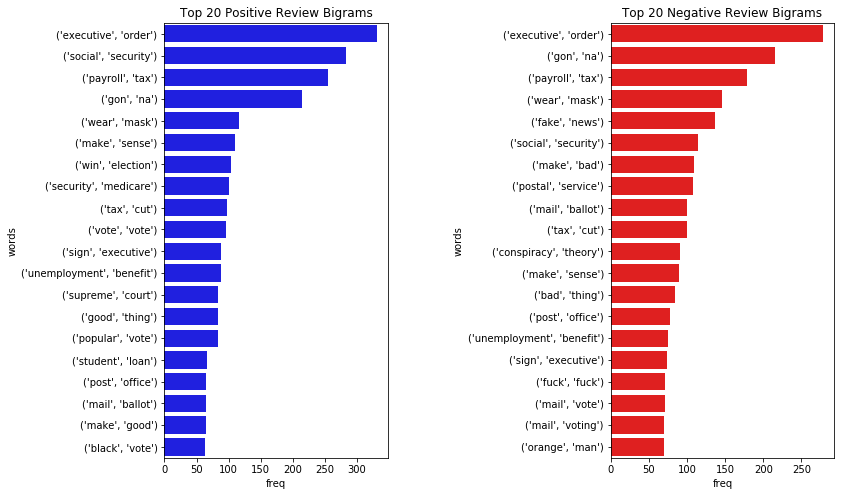

In [97]:
fig,ax=plt.subplots(1,2, figsize=(12,8))
fig.subplots_adjust(wspace=1) #Adjusts the space between the two plots
plotMostCommonWords(top20posBigram,"Top 20 Positive Review Bigrams",axis=ax[0])
plotMostCommonWords(top20negBigram,"Top 20 Negative Review Bigrams",color="red",axis=ax[1])

# Topic Modelling

Reference: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

### Preparing texts for Topic Modelling:

- Removing common English words 
- Tokenize each text into list 
- Combining all tokens to create a stream

In [99]:
# Prepare texts for LDA (not removing duplication)
dfredd['ldatokens'] = dfredd['clean'].apply(lambda x: prepare_text_for_lda(x))
#dfReddUnique['ldatokens'] = dfReddUnique['clean'].apply(lambda x: prepare_text_for_lda(x))
# dfTwitUnique.head()

# creating a word-stream
word_stream = dfredd['ldatokens'].to_list()
#word_stream = dfReddUnique['ldatokens'].to_list()

# Determining the Document Term Matrix 
dictionary = corpora.Dictionary(word_stream)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in word_stream]

### Evaluating the Appropriate Number of Topics using Coherence Model

For simplicity, choose optimum topic between 3 and 10, with highest coherence score

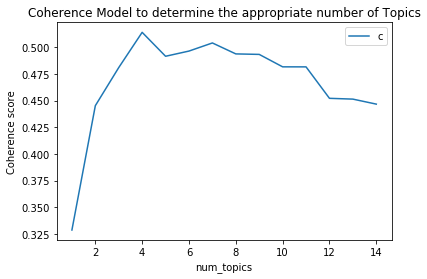

Wall time: 4min 22s


4

In [100]:
%%time
lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=doc_term_matrix, texts=word_stream, limit=15)

# Identify optimum topics (between 3 and 10, with highest coherence score)
optimalTopic = c_v.index(max(c_v[2:10])) + 1
optimalTopic

### Generate the LDA Model

In [101]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix, num_topics = optimalTopic, id2word = dictionary, passes=5)

# Showing top 5 words within Topics 
Topics=ldamodel.print_topics(num_topics=10, num_words=8)

for i in Topics:
    print(i)

(0, '0.027*"vote" + 0.012*"make" + 0.011*"election" + 0.009*"democrat" + 0.009*"party" + 0.008*"win" + 0.008*"fuck" + 0.008*"time"')
(1, '0.011*"supporter" + 0.008*"thing" + 0.008*"make" + 0.008*"black" + 0.007*"political" + 0.007*"racist" + 0.007*"news" + 0.006*"support"')
(2, '0.008*"joe" + 0.007*"eye" + 0.006*"fuck" + 0.005*"restrict" + 0.005*"uncle" + 0.005*"dirty" + 0.005*"donald" + 0.005*"birthday"')
(3, '0.013*"tax" + 0.010*"make" + 0.009*"state" + 0.008*"order" + 0.008*"money" + 0.007*"executive" + 0.006*"pay" + 0.006*"security"')


In [102]:
%%time

# Preparing LDA Model for Display 
lda_display = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=False)

Wall time: 4min 44s


C:\Users\ngwei\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [103]:
# Displaying LDA Model (in Jupyter Notebook)
pyLDAvis.display(lda_display)

# # Showing LDA Model in HTML-browser
# pyLDAvis.show(lda_display)

In [104]:
# # Saving model in HTML file
pyLDAvis.save_html(lda_display, 'static/'+datetime.strftime(varDate, '%m%d%Y')+'redd.html')

In [105]:
reddEndTime = time.time() - starttime

# Part 3: Save Data To CSV

- Reference (index str to datetime): https://stackoverflow.com/questions/40815238/python-pandas-convert-index-to-datetime
- Reference (index datetime to str): https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.strftime.html

In [106]:
# File name: 
myFile = 'static/data.csv'

# Open data file and read into df
df = pd.read_csv(myFile)
df.set_index('date', inplace=True)
# df

# Using Date as unique identifier
strDate = datetime.strftime(varDate, '%m/%d/%Y')

# Append current data (VADER Sentiments)
newRow = pd.Series({'twit_all':oTotalTwit,
                    'twit_all_pos':oTotalPosTwit,
                    'twit_all_neg':oTotalNegTwit,
                    'twit_all_neu':oTotalNeuTwit,
                    'twit_trump':oTrumpTwit,
                    'twit_trump_pos':oTrumpPosTwit,
                    'twit_trump_neg':oTrumpNegTwit,
                    'twit_trump_neu':oTrumpNeuTwit,
                    'twit_biden':oBidenTwit,
                    'twit_biden_pos':oBidenPosTwit,
                    'twit_biden_neg':oBidenNegTwit,
                    'twit_biden_neu':oBidenNeuTwit,
                    'tb_twit_all':nTotalTwit,
                    'tb_twit_all_pos':nTotalPosTwit,
                    'tb_twit_all_neg':nTotalNegTwit,
                    'tb_twit_all_neu':nTotalNeuTwit,
                    'tb_twit_trump':nTrumpTwit,
                    'tb_twit_trump_pos':nTrumpPosTwit,
                    'tb_twit_trump_neg':nTrumpNegTwit,
                    'tb_twit_trump_neu':nTrumpNeuTwit,
                    'tb_twit_biden':nBidenTwit,
                    'tb_twit_biden_pos':nBidenPosTwit,
                    'tb_twit_biden_neg':nBidenNegTwit,
                    'tb_twit_biden_neu':nBidenNeuTwit,
                    'twit_time':twitEndTime,
                    'redd_all':oTotalRedd,
                    'redd_all_pos':oTotalPosRedd,
                    'redd_all_neg':oTotalNegRedd,
                    'redd_all_neu':oTotalNeuRedd,
                    'redd_trump':oTrumpRedd,
                    'redd_trump_pos':oTrumpPosRedd,
                    'redd_trump_neg':oTrumpNegRedd,
                    'redd_trump_neu':oTrumpNeuRedd,
                    'redd_biden':oBidenRedd,
                    'redd_biden_pos':oBidenPosRedd,
                    'redd_biden_neg':oBidenNegRedd,
                    'redd_biden_neu':oBidenNeuRedd,
                    'tb_redd_all':nTotalRedd,
                    'tb_redd_all_pos':nTotalPosRedd,
                    'tb_redd_all_neg':nTotalNegRedd,
                    'tb_redd_all_neu':nTotalNeuRedd,
                    'tb_redd_trump':nTrumpRedd,
                    'tb_redd_trump_pos':nTrumpPosRedd,
                    'tb_redd_trump_neg':nTrumpNegRedd,
                    'tb_redd_trump_neu':nTrumpNeuRedd,
                    'tb_redd_biden':nBidenRedd,
                    'tb_redd_biden_pos':nBidenPosRedd,
                    'tb_redd_biden_neg':nBidenNegRedd,
                    'tb_redd_biden_neu':nBidenNeuRedd,
                    'redd_time':reddEndTime,
                   },name=strDate)
# Add new row, or update existing
df.loc[strDate, newRow.index] = newRow.values


# Sort by ascending date 
df = df.sort_index()

# save CSV
df.to_csv(myFile, index=True)

### Processing Time for Twitter and Reddit Data

In [107]:
print("--- Twitter Part: %s seconds ---" % twitEndTime)
print("--- Reddit Part: %s seconds ---" % reddEndTime)

--- Twitter Part: 1477.0536437034607 seconds ---
--- Reddit Part: 891.9683163166046 seconds ---
